In [1]:
import numpy as np 
import pandas as pd
import torch
import torch.nn as nn
import re
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
import gc
from datetime import datetime
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from transformers import AutoModelForSequenceClassification, AutoTokenizer
from torch.optim import AdamW

In [2]:
# Load Data
test_df = pd.read_csv('twitter_validation.csv', header=None)
train_df = pd.read_csv('twitter_training.csv', header=None)
test_df.reset_index(drop=True, inplace=True)
train_df.reset_index(drop=True, inplace=True)
df1 = pd.concat([train_df, test_df], axis=0)
df1.drop([0], axis=1, inplace=True)
df1.columns = ['platform', 'sentiment', 'text']
df1.drop(['platform'], axis=1, inplace=True)
df1.sentiment = df1.sentiment.map({"Neutral": 0, "Irrelevant": 0, "Positive": 1, "Negative": 2})
df1.dropna(inplace=True)

In [3]:
total_samples = 7500
counts = df1['sentiment'].value_counts(normalize=True)
samples_per_class = (counts * total_samples).round().astype(int)  # Ensure integer sample sizes
# 对每个类别进行抽样
sampled_dfs = []
for sentiment, samples in samples_per_class.items():  # Use items() instead of iteritems()
    sampled_dfs.append(
        df1[df1['sentiment'] == sentiment].sample(n=samples, random_state=42)
    )
df = pd.concat(sampled_dfs).reset_index(drop=True)
df = df.sample(frac=1)

In [4]:
def data_preprocessing(text):
    text = text.lower()
    text = re.sub(r'https?://www\.\S+\.cm', '', text)
    text = re.sub(r'[^a-zA-Z|\s]', '', text)
    text = re.sub(r'\*+', 'swear', text)
    text = re.sub('<.*?>', '', text) # Remove HTML from text
    text = re.sub(r'(.)\1{3,}', r'\1', text)
    return text

df['text'] = df['text'].astype(str).apply(lambda x:data_preprocessing(x))
df.head()

,sentiment,text
446,0,respect the drip steal the baby
5642,1,i really want one
4757,2,this goddamn shit is a two way street man
5708,1,playapex is still the best battle royale even...
333,0,good catch disgusting stunts they belong to ot...


In [5]:
# BERT Tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Dataset
class BERTDataset:
    def __init__(self, texts, sentiments, tokenizer, max_len):
        self.texts = texts
        self.sentiments = sentiments
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        sentiment = self.sentiments[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True,
        )

        return {
            'text': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'sentiment': torch.tensor(sentiment, dtype=torch.long)
        }

In [6]:
# Split Data
y = df.sentiment.values
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=y)

y_temp = temp_df.sentiment.values
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=y_temp)


In [7]:
MAX_LEN = max([len(x.split()) for x in df['text']])
BATCH_SIZE = 16

# DataLoader
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = BERTDataset(
        texts=df.text.to_numpy(),
        sentiments=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=True
    )

train_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
valid_loader = create_data_loader(valid_df, tokenizer, MAX_LEN, BATCH_SIZE)
test_loader = create_data_loader(test_df, tokenizer, MAX_LEN, BATCH_SIZE)

In [8]:
def train_one_epoch(model, train_loader, optimizer, device):
    # set init values 
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    ###################
    # train the model #
    ###################
    model.train()
    for data in tqdm(train_loader, desc="Training"):
        input_ids = data["text"].to(device)
        attention_mask = data["attention_mask"].to(device)
        targets = data["sentiment"].to(device)
        optimizer.zero_grad()
        output = model(input_ids=input_ids,attention_mask=attention_mask,labels=targets)
        loss = output.loss
        logits = output.logits
        preds = torch.argmax(logits, dim=1)
        correct_predictions = torch.sum(preds == targets)
        accuracy = correct_predictions.double() / targets.size(0)

        loss.backward()
        optimizer.step()
        # update training loss and accuracy
        epoch_loss += loss.item()
        epoch_accuracy += accuracy.item()
    return epoch_loss / len(train_loader), epoch_accuracy / len(train_loader)
    
def validate_one_epoch(model, valid_loader, device):
    # set init values
    valid_loss = 0.0
    valid_accuracy = 0.0
    ######################
    # validate the model #
    ######################
    model.eval()
    for data in tqdm(valid_loader,desc="Validation"):
        input_ids = data['text'].to(device)
        attention_mask = data['attention_mask'].to(device)
        targets = data['sentiment'].to(device)
        with torch.no_grad():
            output = model(input_ids=input_ids, attention_mask=attention_mask, labels=targets)
            loss = output.loss
            logits = output.logits
            preds = torch.argmax(logits, dim=1)
            correct_predictions = torch.sum(preds == targets)
            accuracy = correct_predictions.double() / targets.size(0)
            # update average validation loss and accuracy
            valid_loss += loss.item()
            valid_accuracy += accuracy.item()
    return valid_loss / len(valid_loader), valid_accuracy / len(valid_loader)

def evaluate(model, test_loader, device):
    # set init values
    test_loss = 0.0
    test_accuracy = 0.0
    all_preds = []
    all_targets = []
    ######################
    # evaluate the model #
    ######################
    model.eval()
    for data in tqdm(test_loader,desc="Testing"):
        input_ids = data['text'].to(device)
        attention_mask = data['attention_mask'].to(device)
        targets = data['sentiment'].to(device)
        with torch.no_grad():
            output = model(input_ids=input_ids, attention_mask=attention_mask, labels=targets)
            loss = output.loss
            logits = output.logits
            preds = torch.argmax(logits, dim=1)
            correct_predictions = torch.sum(preds == targets)
            accuracy = correct_predictions.double() / targets.size(0)
            # update average test loss and accuracy
            test_loss += loss.item()
            test_accuracy += accuracy.item()
            # get prediction and true values
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    # calculate average losses
    test_loss /= len(test_loader)
    test_accuracy /= len(test_loader)
    return test_loss, test_accuracy, np.array(all_preds), np.array(all_targets)

In [9]:
def fit(
        model, epochs, device, optimizer, train_loader, valid_loader=None
    ):
        # set init values
        valid_loss_min = np.Inf
        train_losses = []
        valid_losses = []
        train_accs = []
        valid_accs = []
        # set the logic about epoch
        for epoch in range(1, epochs + 1):
            # clear useless data
            gc.collect()

            print(f"{'='*50}")
            print(f"EPOCH {epoch} - TRAINING...")
            train_loss, train_acc = train_one_epoch(model,
                train_loader, optimizer, device
            )
            print(
                f"\n\t[TRAIN] EPOCH {epoch} - LOSS: {train_loss}, ACCURACY: {train_acc}\n"
            )
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            gc.collect()

            if valid_loader is not None:
                gc.collect()
            
                print(f"EPOCH {epoch} - VALIDATING...")
                valid_loss, valid_acc = validate_one_epoch(model,
                    valid_loader, device
                )
                print(f"\t[VALID] LOSS: {valid_loss}, ACCURACY: {valid_acc}\n")
                valid_losses.append(valid_loss)
                valid_accs.append(valid_acc)
                gc.collect()

                # show if validation loss has decreased
                if valid_loss <= valid_loss_min and epoch != 1:
                    print(
                        "Validation loss decreased ({:.4f} --> {:.4f}).".format(
                            valid_loss_min, valid_loss
                        )
                    )
                valid_loss_min = valid_loss

        return {
            "train_loss": train_losses,
            "valid_loss": valid_losses,
            "train_acc": train_accs,
            "valid_acc": valid_accs,
        }

In [10]:
# BERT Model
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
device = torch.device("cpu")
model.to(device)
optimizer = AdamW(model.parameters(), lr=1e-6)

# record start time
print(f"INITIALIZING TRAINING ")
start_time = datetime.now()
print(f"Start Time: {start_time}")
# train model
logs = fit(
    model=model,
    epochs=10,
    device=device,
    optimizer=optimizer,
    train_loader=train_loader,
    valid_loader=valid_loader,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


INITIALIZING TRAINING 
Start Time: 2024-04-03 20:29:35.340009
EPOCH 1 - TRAINING...


Training: 100%|██████████| 329/329 [40:37<00:00,  7.41s/it]



	[TRAIN] EPOCH 1 - LOSS: 1.0862255353695716, ACCURACY: 0.3890577507598784

EPOCH 1 - VALIDATING...


Validation: 100%|██████████| 71/71 [02:50<00:00,  2.40s/it]


	[VALID] LOSS: 1.0564681467875627, ACCURACY: 0.4195422535211268

EPOCH 2 - TRAINING...


Training: 100%|██████████| 329/329 [40:30<00:00,  7.39s/it]



	[TRAIN] EPOCH 2 - LOSS: 1.0370034265663124, ACCURACY: 0.44832826747720367

EPOCH 2 - VALIDATING...


Validation: 100%|██████████| 71/71 [02:50<00:00,  2.41s/it]


	[VALID] LOSS: 0.9860162248074169, ACCURACY: 0.49154929577464784

Validation loss decreased (1.0565 --> 0.9860).
EPOCH 3 - TRAINING...


Training: 100%|██████████| 329/329 [40:25<00:00,  7.37s/it]



	[TRAIN] EPOCH 3 - LOSS: 0.9575476854767843, ACCURACY: 0.5364741641337386

EPOCH 3 - VALIDATING...


Validation: 100%|██████████| 71/71 [02:50<00:00,  2.41s/it]


	[VALID] LOSS: 0.9087990749050194, ACCURACY: 0.569894366197183

Validation loss decreased (0.9860 --> 0.9088).
EPOCH 4 - TRAINING...


Training: 100%|██████████| 329/329 [40:24<00:00,  7.37s/it]



	[TRAIN] EPOCH 4 - LOSS: 0.8864475265824686, ACCURACY: 0.5879559270516718

EPOCH 4 - VALIDATING...


Validation: 100%|██████████| 71/71 [02:51<00:00,  2.41s/it]


	[VALID] LOSS: 0.8573943300985954, ACCURACY: 0.5954225352112675

Validation loss decreased (0.9088 --> 0.8574).
EPOCH 5 - TRAINING...


Training: 100%|██████████| 329/329 [40:24<00:00,  7.37s/it]



	[TRAIN] EPOCH 5 - LOSS: 0.8361653377582237, ACCURACY: 0.6147416413373861

EPOCH 5 - VALIDATING...


Validation: 100%|██████████| 71/71 [02:51<00:00,  2.41s/it]


	[VALID] LOSS: 0.8328549618452368, ACCURACY: 0.6121478873239437

Validation loss decreased (0.8574 --> 0.8329).
EPOCH 6 - TRAINING...


Training: 100%|██████████| 329/329 [40:26<00:00,  7.37s/it]



	[TRAIN] EPOCH 6 - LOSS: 0.7954709198337195, ACCURACY: 0.6388677811550152

EPOCH 6 - VALIDATING...


Validation: 100%|██████████| 71/71 [02:51<00:00,  2.41s/it]


	[VALID] LOSS: 0.811882068573589, ACCURACY: 0.6195422535211267

Validation loss decreased (0.8329 --> 0.8119).
EPOCH 7 - TRAINING...


Training: 100%|██████████| 329/329 [40:28<00:00,  7.38s/it]



	[TRAIN] EPOCH 7 - LOSS: 0.7618656496327699, ACCURACY: 0.6633738601823708

EPOCH 7 - VALIDATING...


Validation: 100%|██████████| 71/71 [02:50<00:00,  2.41s/it]


	[VALID] LOSS: 0.8123646697527925, ACCURACY: 0.6137323943661972

EPOCH 8 - TRAINING...


Training: 100%|██████████| 329/329 [40:26<00:00,  7.38s/it]



	[TRAIN] EPOCH 8 - LOSS: 0.735866237828072, ACCURACY: 0.6770516717325228

EPOCH 8 - VALIDATING...


Validation: 100%|██████████| 71/71 [02:50<00:00,  2.39s/it]


	[VALID] LOSS: 0.7930669734175776, ACCURACY: 0.6360915492957747

Validation loss decreased (0.8124 --> 0.7931).
EPOCH 9 - TRAINING...


Training: 100%|██████████| 329/329 [40:31<00:00,  7.39s/it]



	[TRAIN] EPOCH 9 - LOSS: 0.709537723144137, ACCURACY: 0.6971884498480243

EPOCH 9 - VALIDATING...


Validation: 100%|██████████| 71/71 [02:50<00:00,  2.40s/it]


	[VALID] LOSS: 0.7902711113573799, ACCURACY: 0.6424295774647887

Validation loss decreased (0.7931 --> 0.7903).
EPOCH 10 - TRAINING...


Training: 100%|██████████| 329/329 [40:25<00:00,  7.37s/it]



	[TRAIN] EPOCH 10 - LOSS: 0.6875956118288011, ACCURACY: 0.7078267477203647

EPOCH 10 - VALIDATING...


Validation: 100%|██████████| 71/71 [02:52<00:00,  2.42s/it]

	[VALID] LOSS: 0.7864708510083211, ACCURACY: 0.6466549295774648

Validation loss decreased (0.7903 --> 0.7865).


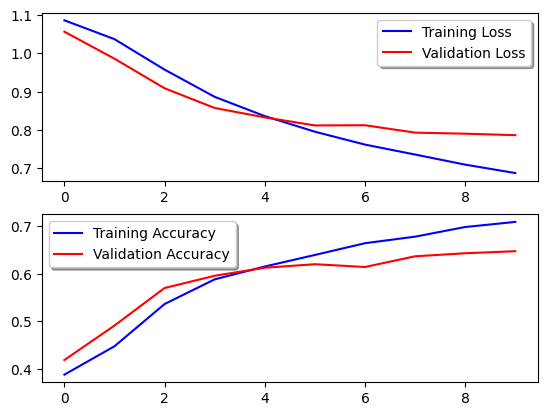

In [11]:
fig, ax = plt.subplots(2,1)
ax[0].plot(logs['train_loss'], color='b', label="Training Loss")
ax[0].plot(logs['valid_loss'], color='r', label="Validation Loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(logs['train_acc'], color='b', label="Training Accuracy")
ax[1].plot(logs['valid_acc'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [12]:
test_loss, test_acc, all_preds, all_targets = evaluate(model, test_loader, device)
print(f"\t[TEST] LOSS: {test_loss}, ACCURACY: {test_acc}\n")

Testing: 100%|██████████| 71/71 [02:50<00:00,  2.40s/it]

	[TEST] LOSS: 0.7997861655665116, ACCURACY: 0.6450704225352112



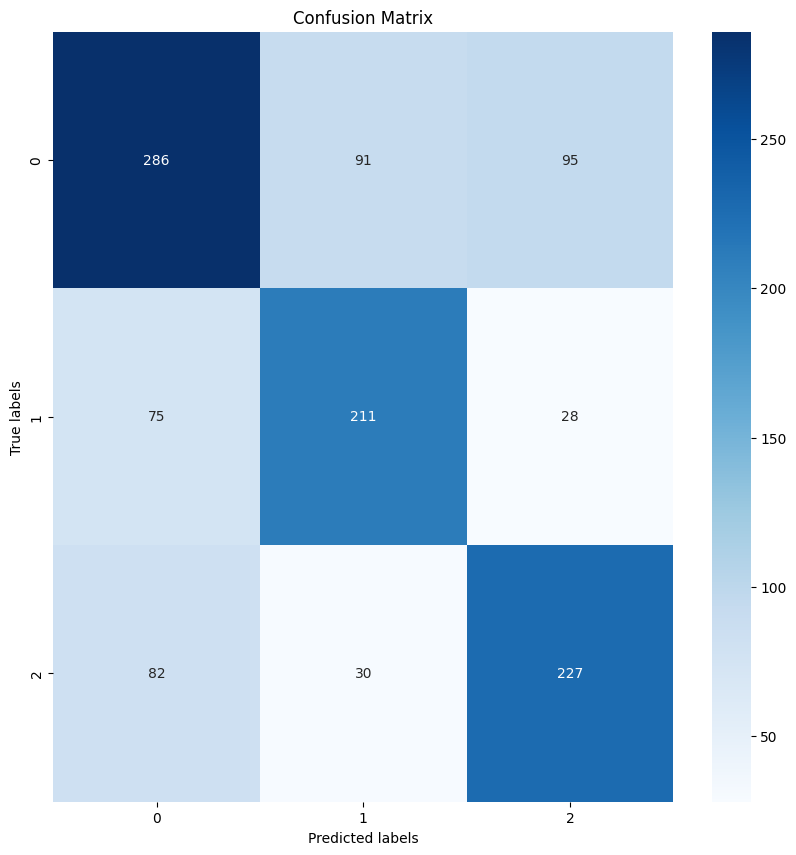

In [13]:
# Calculate confusion matrix
conf_mat = confusion_matrix(all_targets, all_preds)
fig, ax = plt.subplots(figsize=(10, 10))
# plot it
sns.heatmap(conf_mat, annot=True, fmt='d', ax=ax, cmap="Blues")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

In [14]:
# make performance metrics for each classes
accuracy = accuracy_score(all_targets, all_preds)
print(accuracy)

0.6435555555555555


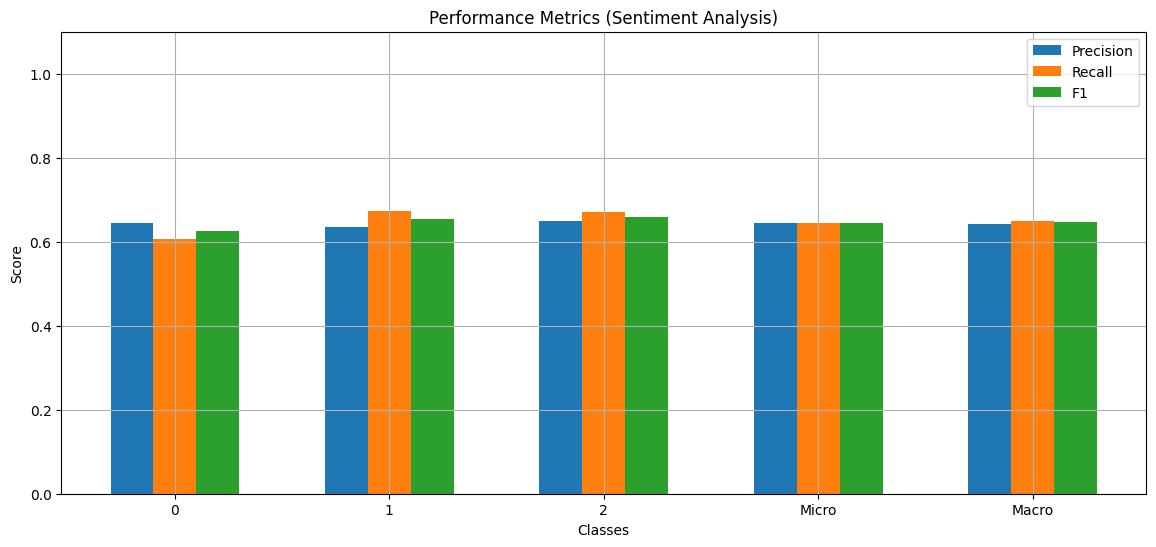

In [15]:
# define the values in normal, micro and macro state
num_classes = 3

precision = precision_score(all_targets, all_preds, average=None)
precision_micro = precision_score(all_targets, all_preds, average='micro')
precision_macro = precision_score(all_targets, all_preds, average='macro')

recall = recall_score(all_targets, all_preds, average=None)
recall_micro = recall_score(all_targets, all_preds, average='micro')
recall_macro = recall_score(all_targets, all_preds, average='macro')

f1 = f1_score(all_targets, all_preds, average=None)
f1_micro = f1_score(all_targets, all_preds, average='micro')
f1_macro= f1_score(all_targets, all_preds, average='macro')

precision = np.append(precision, [precision_micro, precision_macro])
recall = np.append(recall, [recall_micro, recall_macro])
f1 = np.append(f1, [f1_micro, f1_macro])
classes = list(range(num_classes)) + ['Micro', 'Macro']

x = np.arange(len(classes))
width = 0.2

fig1, ax1 = plt.subplots(figsize=(14, 6))
rects1 = ax1.bar(x - width, precision, width, label='Precision')
rects2 = ax1.bar(x, recall, width, label='Recall')
rects3 = ax1.bar(x + width, f1, width, label='F1')

ax1.set_xlabel('Classes')
ax1.set_ylabel('Score')
ax1.set_title('Performance Metrics (Sentiment Analysis)')
ax1.set_xticks(x)
ax1.set_xticklabels(classes)
ax1.set_ylim(0, 1.1)
ax1.legend(loc='upper right')
ax1.grid(True)
plt.show()